# Dependencies

In [1]:
import os, warnings, shutil, re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import AutoTokenizer
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold


SEED = 0
warnings.filterwarnings("ignore")
pd.set_option('max_colwidth', 160)

In [2]:
# Preprocess data
def clean_text(text):
    text = str(text)
    text = re.sub(r'[0-9"]', '', text) # number
    text = re.sub(r'#[\S]+\b', '', text) # hash
    text = re.sub(r'@[\S]+\b', '', text) # mention
    text = re.sub(r'https?\S+', '', text) # link
    text = re.sub(r'\s+', ' ', text) # multiple white spaces
#     text = re.sub(r'\W+', ' ', text) # non-alphanumeric
    return text.strip()\

# Preprocess inputs
CLS = 0
PAD = 1
SEP = 2

def preprocess_roberta(text, tokenizer, max_seq_len):
    encoded = tokenizer.encode_plus(text, return_token_type_ids=False)
    
    # Truncate
    input_ids = encoded['input_ids'][:max_seq_len]
    attention_mask = encoded['attention_mask'][:max_seq_len]
    
    # Update input_ids
    input_ids[0] = CLS
    input_ids[-1] = SEP
    
    # Pad
    input_ids = input_ids + [PAD] * (max_seq_len - len(input_ids))
    attention_mask = attention_mask + [0] * (max_seq_len - len(attention_mask))
    
    x = [np.asarray(input_ids, dtype=np.int32), 
         np.asarray(attention_mask, dtype=np.int8)]
    
    return x

def preprocess_roberta_tail(text, tokenizer, max_seq_len):
    encoded = tokenizer.encode_plus(text, return_token_type_ids=False)
    
    # Truncate
    input_ids = encoded['input_ids'][-max_seq_len:]
    attention_mask = encoded['attention_mask'][-max_seq_len:]
    
    # Update input_ids
    input_ids[0] = CLS
    input_ids[-1] = SEP
    
    # Pad
    input_ids = input_ids + [PAD] * (max_seq_len - len(input_ids))
    attention_mask = attention_mask + [0] * (max_seq_len - len(attention_mask))
    
    x = [np.asarray(input_ids, dtype=np.int32), 
         np.asarray(attention_mask, dtype=np.int8)]
    
#     if len(encoded['input_ids']) > max_seq_len:
#         return x
#     else:
#         return None
    return x

def preprocess_roberta_tail_test(text, tokenizer, max_seq_len):
    encoded = tokenizer.encode_plus(text, return_token_type_ids=False)
    
    # Truncate
    input_ids = encoded['input_ids'][-max_seq_len:]
    attention_mask = encoded['attention_mask'][-max_seq_len:]
    
    # Update input_ids
    input_ids[0] = CLS
    input_ids[-1] = SEP
    
    # Pad
    input_ids = input_ids + [PAD] * (max_seq_len - len(input_ids))
    attention_mask = attention_mask + [0] * (max_seq_len - len(attention_mask))
    
    x = [np.asarray(input_ids, dtype=np.int32), 
         np.asarray(attention_mask, dtype=np.int8)]
    
    return x

def get_data(df, text_col, tokenizer, MAX_LEN, preprocess_fn=preprocess_roberta):
    x_input_ids = []
    x_attention_masks = []
    y_data = []
    y_data_int = []
    
    for row in df.itertuples(): 
        x = preprocess_fn(getattr(row, text_col), tokenizer, MAX_LEN)
        if x is not None:
            x_input_ids.append(x[0])
            x_attention_masks.append(x[1])

            y_data.append(getattr(row, 'toxic'))

    x_data = [np.asarray(x_input_ids, dtype=np.int32), 
              np.asarray(x_attention_masks, dtype=np.int8)]
    
    y_data = np.asarray(y_data, dtype=np.float32)
    
    return x_data, y_data

def get_data_test(df, text_col, tokenizer, MAX_LEN, preprocess_fn=preprocess_roberta):
    x_input_ids = []
    x_attention_masks = []
    
    for row in df.itertuples(): 
        x = preprocess_fn(getattr(row, text_col), tokenizer, MAX_LEN)
        x_input_ids.append(x[0])
        x_attention_masks.append(x[1])


    x_data = [np.asarray(x_input_ids, dtype=np.int32), 
              np.asarray(x_attention_masks, dtype=np.int8)]
    
    return x_data

# Parameters

In [3]:
MAX_LEN = 192
tokenizer_path = 'jplu/tf-xlm-roberta-large'
sample_rate = 3

# Load data

In [4]:
open_subtitles = pd.read_csv('/kaggle/input/open-subtitles-toxic-pseudo-labeling/open-subtitles-synthesic.csv')

n_neg_samp_open = len(open_subtitles.query('toxic > .5')) * sample_rate

open_subtitles = pd.concat([open_subtitles[['comment_text', 'toxic']].query('toxic > .5'),
                            open_subtitles[['comment_text', 'toxic']].query('toxic <= .5').sample(n=n_neg_samp_open, random_state=SEED)
                           ])

print(f'Open subtitles samples: toxic|non-toxic | {n_neg_samp_open // sample_rate}|{n_neg_samp_open}')
display(open_subtitles.head())
display(open_subtitles.describe())

Open subtitles samples: toxic|non-toxic | 144493|433479


,comment_text,toxic
13,"Tu vas virer ces fils de putes de Patriotes, et ensuite ? Tu vas te retirer ?",1
15,Non avete imparato la lezione l'ultima volta che vi ho sbudellato?,1
17,"Evet, sen de bu yüzden benden sopa yiyecek olan olmalısın.",1
19,Je veux vos miches sur ce putain de coup.,1
39,"Kokuyor, Lila. Domuz gibi bir fahişenin deliği gibi kokuyor.",1


,toxic
count,577972.000000
mean,0.250000
std,0.433013
min,0.000000
25%,0.000000
50%,0.000000
75%,0.250000
max,1.000000


# Tokenizer

In [5]:
tokenizer = AutoTokenizer.from_pretrained(tokenizer_path, lowercase=False)

## Preprocess

In [6]:
# Open subtitles
open_subtitles['comment_text'] = open_subtitles.apply(lambda x: clean_text(x['comment_text']), axis=1)
open_subtitles['length'] = open_subtitles['comment_text'].apply(lambda x : len(x))
open_subtitles['word_count'] = open_subtitles['comment_text'].apply(lambda x : len(x.split(' ')))
open_subtitles['token_count'] = open_subtitles['comment_text'].apply(lambda x : len(tokenizer.encode(x)))

print('Open subtitles samples %d' % len(open_subtitles))
display(open_subtitles.head())
display(open_subtitles.describe())

Open subtitles samples 577972


,comment_text,toxic,length,word_count,token_count
13,"Tu vas virer ces fils de putes de Patriotes, et ensuite ? Tu vas te retirer ?",1,77,17,24
15,Non avete imparato la lezione l'ultima volta che vi ho sbudellato?,1,66,11,20
17,"Evet, sen de bu yüzden benden sopa yiyecek olan olmalısın.",1,58,10,17
19,Je veux vos miches sur ce putain de coup.,1,41,9,14
39,"Kokuyor, Lila. Domuz gibi bir fahişenin deliği gibi kokuyor.",1,60,9,22


,toxic,length,word_count,token_count
count,577972.000000,577972.000000,577972.000000,577972.000000
mean,0.250000,42.765092,7.316405,14.015279
std,0.433013,25.515479,4.391044,6.550663
min,0.000000,1.000000,1.000000,3.000000
25%,0.000000,26.000000,4.000000,10.000000
50%,0.000000,36.000000,6.000000,12.000000
75%,0.250000,52.000000,9.000000,16.000000
max,1.000000,365.000000,60.000000,79.000000


## Filter

In [7]:
# open_subtitles = open_subtitles[open_subtitles['word_count'] <= 250]
# open_subtitles = open_subtitles[open_subtitles['token_count'] <= 1000]
open_subtitles = shuffle(open_subtitles, random_state=SEED).reset_index(drop=True)

print('Open subtitles samples %d' % len(open_subtitles))
display(open_subtitles.head())
display(open_subtitles.describe())

Open subtitles samples 577972


,comment_text,toxic,length,word_count,token_count
0,Comme celui qu'on donne dans les loges?,0,39,7,13
1,"Kusura bakma, olacak şey değildi.",0,33,5,12
2,- Gelecek haberleri bekliyoruz. - Yalan söyledi.,0,48,7,13
3,Tenho problemas de dinheiro...,0,30,4,7
4,Neden o koyduğumun astronotlarına bu derece takıntılısın?,1,57,7,17


,toxic,length,word_count,token_count
count,577972.000000,577972.000000,577972.000000,577972.000000
mean,0.250000,42.765092,7.316405,14.015279
std,0.433013,25.515479,4.391044,6.550663
min,0.000000,1.000000,1.000000,3.000000
25%,0.000000,26.000000,4.000000,10.000000
50%,0.000000,36.000000,6.000000,12.000000
75%,0.250000,52.000000,9.000000,16.000000
max,1.000000,365.000000,60.000000,79.000000


# Data generation sanity check

In [8]:
for idx in range(5):
    print('\nRow %d' % idx)
    max_seq_len = 32
    comment_text = open_subtitles['comment_text'].loc[idx]
    
    x_train_open, y_train_open = get_data(open_subtitles[idx:idx+1], 'comment_text', tokenizer, max_seq_len, preprocess_fn=preprocess_roberta)
    
    print('label         : "%.4f"' % y_train_open)
    print('comment_text  : "%s"'   % comment_text)
    print('input_ids     : "%s"'   % x_train_open[0][0])
    print('attention_mask: "%s"'   % x_train_open[1][0])
    
    x_train_open, _ = get_data(open_subtitles[idx:idx+1], 'comment_text', tokenizer, max_seq_len, preprocess_fn=preprocess_roberta_tail)
    if len(x_train_open[0]) > 0:
        print('-------------------- TAIL --------------------')

        print('input_ids     : "%s"' % x_train_open[0][0])
        print('attention_mask: "%s"' % x_train_open[1][0])

        assert len(x_train_open[0][0]) == len(x_train_open[1][0]) == max_seq_len


Row 0
label         : "0.0000"
comment_text  : "Comme celui qu'on donne dans les loges?"
input_ids     : "[    0 30964 23814  1103    25   191 17302   807   199 12684    90    32
     2     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1]"
attention_mask: "[1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]"
-------------------- TAIL --------------------
input_ids     : "[    0 30964 23814  1103    25   191 17302   807   199 12684    90    32
     2     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1]"
attention_mask: "[1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]"

Row 1
label         : "0.0000"
comment_text  : "Kusura bakma, olacak şey değildi."
input_ids     : "[    0  1461 52546  3472   192     4 22319  8515  8935   428     5     2
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1  

# Open subtitles set

In [9]:
display(open_subtitles.head())
display(open_subtitles.describe())

x_train_open, y_train_open = get_data(open_subtitles, 'comment_text', tokenizer, MAX_LEN, preprocess_fn=preprocess_roberta)
x_train_open, y_train_open =  np.asarray(x_train_open), np.asarray(y_train_open)

np.save('x_train_open', x_train_open)
np.save('y_train_open', y_train_open)
print('x_train_open shape:', x_train_open.shape)
print('y_train_open shape:', y_train_open.shape)

# #################### ENCODE TAIL ONLY ####################

# x_train_open, y_train_open = get_data(open_subtitles, 'comment_text', tokenizer, MAX_LEN, preprocess_fn=preprocess_roberta_tail)
# x_train_open, y_train_open =  np.asarray(x_train_open), np.asarray(y_train_open)

# np.save('x_train_open_tail', x_train_open)
# np.save('y_train_open_tail', y_train_open)
# print('[TAIL] x_train_open shape:', x_train_open.shape)
# print('[TAIL] y_train_open shape:', y_train_open.shape)

,comment_text,toxic,length,word_count,token_count
0,Comme celui qu'on donne dans les loges?,0,39,7,13
1,"Kusura bakma, olacak şey değildi.",0,33,5,12
2,- Gelecek haberleri bekliyoruz. - Yalan söyledi.,0,48,7,13
3,Tenho problemas de dinheiro...,0,30,4,7
4,Neden o koyduğumun astronotlarına bu derece takıntılısın?,1,57,7,17


,toxic,length,word_count,token_count
count,577972.000000,577972.000000,577972.000000,577972.000000
mean,0.250000,42.765092,7.316405,14.015279
std,0.433013,25.515479,4.391044,6.550663
min,0.000000,1.000000,1.000000,3.000000
25%,0.000000,26.000000,4.000000,10.000000
50%,0.000000,36.000000,6.000000,12.000000
75%,0.250000,52.000000,9.000000,16.000000
max,1.000000,365.000000,60.000000,79.000000


x_train_open shape: (2, 577972, 192)
y_train_open shape: (577972,)


# External data set EDA

## Word count distribution

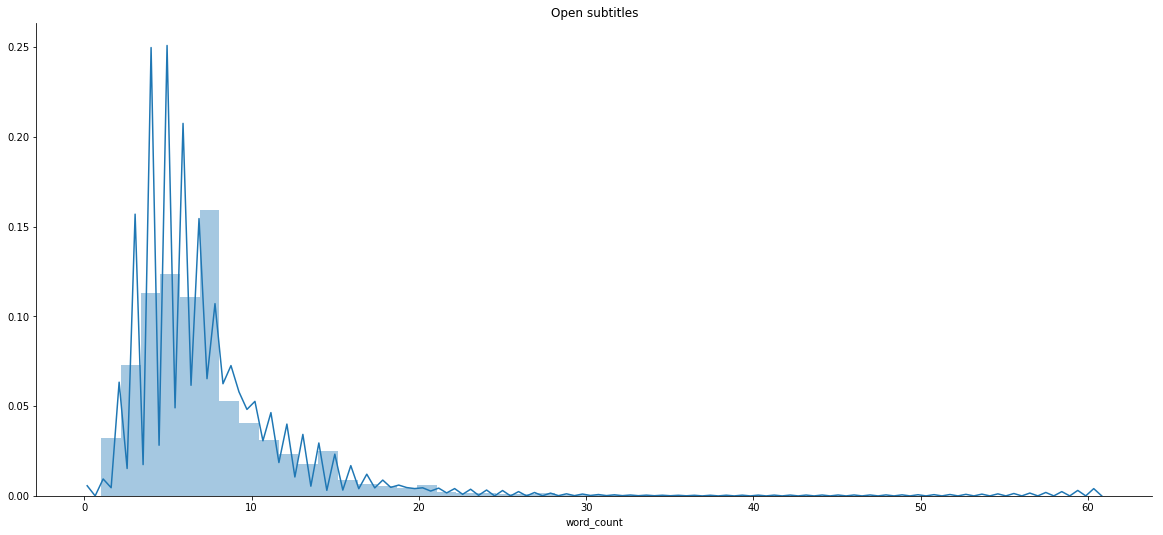

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(20, 8.7), sharex=True)
sns.distplot(open_subtitles['word_count'], ax=ax).set_title("Open subtitles")
sns.despine()
plt.show()

## Token count distribution

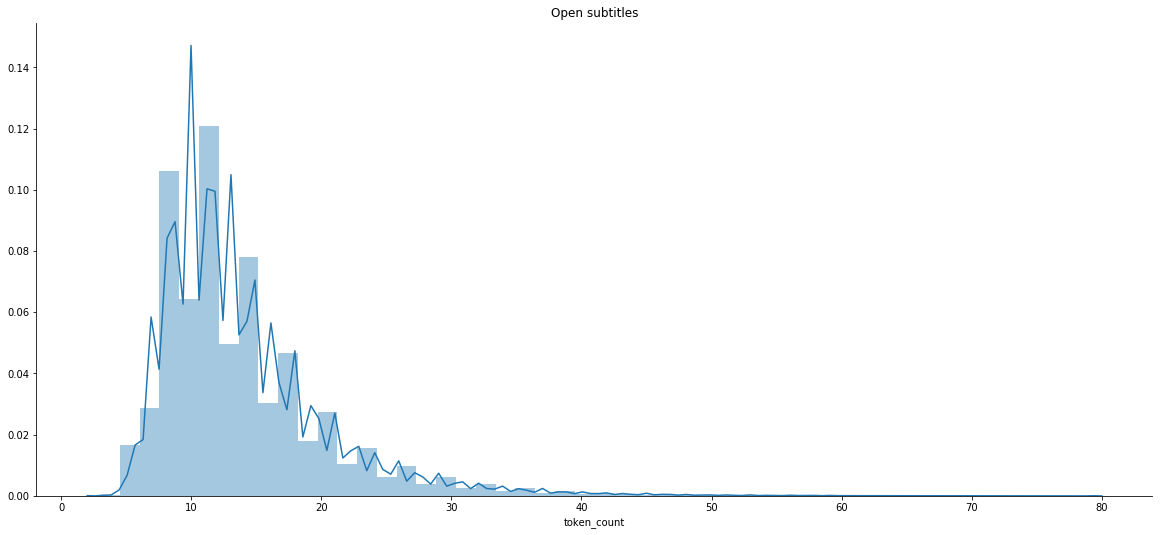

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(20, 8.7), sharex=True)
sns.distplot(open_subtitles['token_count'], ax=ax).set_title("Open subtitles")
sns.despine()
plt.show()